In [1]:
import numpy as np

# Some functions used by naive bayes

def separateByClass(X, y):
    separated = {}
    N, D = X.shape
    for i in range(N):
        vector = X[i]
        classValue = y[i]
        if (classValue not in separated):
            separated[classValue] = []
        separated[classValue].append(vector)    
    return separated

# Summarises data by computing mean and std dev
def summarise(X, featureTypes):
    attributes = zip(*X)    
    N = len(attributes)
   
    #print "number of inputs to be summarised", N    
    #print attributes
    
    summaries = np.empty(N, dtype=object)

    for i in range(N):
        attribute = attributes[i]
        #print attribute
        if featureTypes[i] == 'r':
            summaries[i] = (mean(attribute), stddev(attribute))
        else:
            p = bernoulliMean(attribute)
            summaries[i] = (p, p*(1-p))  

    return summaries
    
def summariseByClass(X, y, featureTypes):
    separated = separateByClass(X, y)
    #rint separated
    summaries = {}
    for classValue, instances in separated.iteritems():
        summaries[classValue] = summarise(instances, featureTypes)
    return summaries

def bernoulliMean(numbers):
    return numbers.count(1)/float(len(numbers))
    
def mean(numbers):
    #print numbers, "=", sum(numbers)
    return sum(numbers)/float(len(numbers))
 
def stddev(numbers):
    avg = mean(numbers)
    variance = sum([pow(x-avg,2) for x in numbers])/float(len(numbers)-1)
    return math.sqrt(variance)

# computes percentage of correctly guessed results
def getAccuracy(predicted, actual):
    numElements = len(predicted)
    #print numElements
    correct = 0
    for i in range(numElements):
        if actual[i] == predicted[i]:
            correct += 1
    return (correct/float(numElements))
        


In [2]:
import numpy as np
from collections import Counter
import math
import scipy.stats

class NBC:
    def __init__(self, feature_types, num_classes):
        self.feature_types = feature_types 
        self.num_classes = num_classes
        self.summary = {}
        self.N = 0
        self.D = 0
        self.pi = {}        
        
        print "New NBC created",self.feature_types, self.num_classes, self.pi

        
    def getFeatures(self):
        return self.feature_types
    
    def getNumClasses(self):
        return self.num_classes
    
    def getPiDict(self):
        return self.pi
    
    # Estimates all parameters of the NBC
    # Models binary features as Bernoulli RVs
    # Models real-valued features as univariate Gaussians
    # Estimates class probabilities PIc = p(y=c)
    def fit(self, X, y):
        self.N, self.D = X.shape
        
        # count classes
        self.pi = dict(Counter(y))
        # now divide by total to converty to p(y=c)
        total = sum(self.pi.itervalues(), 0.0)
        self.pi = {k: v / total for k, v in self.pi.iteritems()}
        
        # determine mean and variance of each class, for each attribute
        # dictionary keyed on class value, 
        # with array as value with each array index corresponding to the attribute at that index
        # so summary[class][attributeIndex] = (mean , variance)
        self.summary = summariseByClass(X, y, self.feature_types)
        #self.computeGaussianParameters(X, y)
       # print self.summary
        
        
    def calculateClassProbabilities(self, inputVector):
        probabilities = {}
        for classValue, classSummaries in self.summary.iteritems():
            probabilities[classValue] = math.log(self.pi[classValue])
            # iterate over features
            for i in range(len(classSummaries)):
                mean, stddev = classSummaries[i]
                x = inputVector[i]

                # Real value
                if self.feature_types[i] == 'r':
                    #print "X", i ,"=", x, "mean = ", mean, "stddev = ", stddev
                    normPDFvalue = scipy.stats.norm(mean, stddev).pdf(x)
                    # very small probability densities get rounded down to zero which gives an error if logged
                    if normPDFvalue != 0:
                        probabilities[classValue] += math.log(normPDFvalue)
                # binary
                else:
                    if x == 1:
                        probabilityOfData = mean
                    else: #x == 0
                        probabilityOfData = 1 - mean
                        
                    if probabilityOfData != 0:                    
                        probabilities[classValue] += math.log(probabilityOfData)
                    
        return probabilities

        
        
    # Computes the class conditional probabilities for the new inputs on all classes, then returns the largest one
    def predict(self, X):
        N, D = X.shape
        #print N

        yhat = np.zeros(N)
        for i in range(N):
            inputVector = X[i]
            probabilities = self.calculateClassProbabilities(inputVector)
            #print('Probabilities for each class: {0}').format(probabilities)
            yhat[i] = max(probabilities, key=probabilities.get)
        return yhat


        
    def test(self):
        self.summary = {0:[(1, 0.5)], 1:[(20, 5.0)]}
        inputVector = [1.1]
        probabilities = self.calculateClassProbabilities(inputVector)
        print probabilities
        

    

In [7]:
from sklearn.datasets import load_iris
import cPickle as cp
from sklearn.linear_model import LogisticRegression

# Iris Dataset
iris = load_iris()
X, y = iris['data'], iris['target']
nbc = NBC(feature_types = ['r','r','r','r'], num_classes = 3)

lr = LogisticRegression()

# Hand in 1
lr.fit(X=X, y=y) 
w = lr.coef_
C = (w[0].T).dot(w[0])
C *= 0.1
print "w =", w[0]
print "C =1 /", C


NUM_PERMUTATIONS = 10

# values for plot
xDataNBC = []
yDataNBC = []
xDataLR = []
yDataLR = []

N, D = X.shape

print "Starting training with", NUM_PERMUTATIONS, "permutations"

# dont include 100%, otherwise we have nothing to test against.
for k in range(1, 10):
    accuracyNBC = 0
    accuracyLR = 0
    Ntrain = int((k/float(10)) * N)
    print "Training on", Ntrain, "values"

    for permutation in range(NUM_PERMUTATIONS):
        #print N
        #print Ntrain
        shuffler = np.random.permutation(N)
        Xtrain = X[shuffler[:Ntrain]]
        ytrain = y[shuffler[:Ntrain]]
        Xtest = X[shuffler[Ntrain:]]
        ytest = y[shuffler[Ntrain:]]

        # NBC
        nbc.fit(Xtrain,ytrain)
        predictedNBC = nbc.predict(Xtest)
        accuracyNBC += getAccuracy(actual=ytest, predicted=predictedNBC)


        # Logisitic Regression
        lr.fit(X=Xtrain, y=ytrain) 
        predictedLR = lr.predict(Xtest)
        accuracyLR += getAccuracy(actual=ytest, predicted=predictedLR)

   
    accuracyNBC /= NUM_PERMUTATIONS
    accuracyLR /= NUM_PERMUTATIONS

    
    xDataNBC.append(Ntrain)
    yDataNBC.append(accuracyNBC)
    xDataLR.append(Ntrain)
    yDataLR.append(accuracyLR)
    
print "Finished Training"

New NBC created ['r', 'r', 'r', 'r'] 3 {}
w = [ 0.41498833  1.46129739 -2.26214118 -1.0290951 ]
C =1 / 0.848392479932
Starting training with 10 permutations
Training on 15 values
Training on 30 values
Training on 45 values
Training on 60 values
Training on 75 values
Training on 90 values
Training on 105 values
Training on 120 values
Training on 135 values
Finished Training


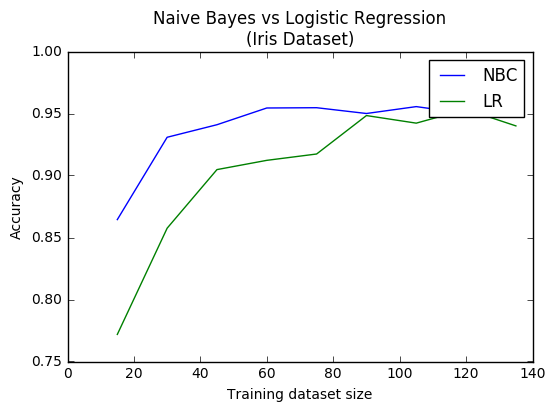

In [8]:
import matplotlib.pyplot as plt

plt.plot(xDataNBC, yDataNBC, 'b-', label='NBC')
plt.plot(xDataLR, yDataLR, 'g-', label='LR')
plt.xlabel('Training dataset size')
plt.ylabel('Accuracy')
plt.title('Naive Bayes vs Logistic Regression\n(Iris Dataset)')
plt.legend()
plt.show()


In [5]:
# Voting dataset
X, y = cp.load(open('voting.cPickle','rb'))
nbc = NBC(feature_types = ['b','b','b','b','b','b','b','b','b','b','b','b','b','b','b','b'], num_classes = 2)

NUM_PERMUTATIONS = 100


lr = LogisticRegression()

# Hand in 1
lr.fit(X=X, y=y) 
w = lr.coef_
C = (w[0].T).dot(w[0])
C *= 0.1
print "w =", w[0]
print "C =1 /", C


# values for plot
xDataNBC = []
yDataNBC = []
xDataLR = []
yDataLR = []

N, D = X.shape

print "Starting training with", NUM_PERMUTATIONS, "permutations"

# dont include 100%, otherwise we have nothing to test against.
for k in range(1, 10):
    accuracyNBC = 0
    accuracyLR = 0
    Ntrain = int((k/float(10)) * N)
    print "Training on", Ntrain, "values"

    for permutation in range(NUM_PERMUTATIONS):
        #print N
        #print Ntrain
        shuffler = np.random.permutation(N)
        Xtrain = X[shuffler[:Ntrain]]
        ytrain = y[shuffler[:Ntrain]]
        Xtest = X[shuffler[Ntrain:]]
        ytest = y[shuffler[Ntrain:]]

        # NBC
        nbc.fit(Xtrain,ytrain)
        predictedNBC = nbc.predict(Xtest)
        accuracyNBC += getAccuracy(actual=ytest, predicted=predictedNBC)


        # Logisitic Regression
        lr.fit(X=Xtrain, y=ytrain) 
        predictedLR = lr.predict(Xtest)
        accuracyLR += getAccuracy(actual=ytest, predicted=predictedLR)
   
    accuracyNBC /= NUM_PERMUTATIONS
    accuracyLR /= NUM_PERMUTATIONS

    
    xDataNBC.append(Ntrain)
    yDataNBC.append(accuracyNBC)
    xDataLR.append(Ntrain)
    yDataLR.append(accuracyLR)
    
print "Finished Training"

New NBC created ['b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b'] 2 {}
w = [ 0.02257628  0.3160212   1.31562407 -3.5622393  -0.47959961  0.5846085
 -0.11030441  0.37157447  0.84092889 -0.73594702  1.74140557 -0.4353211
 -0.14807088 -0.56243805  0.46495679 -0.03082241]
C =1 / 2.026898578
Starting training with 100 permutations
Training on 23 values
Training on 46 values
Training on 69 values
Training on 92 values
Training on 116 values
Training on 139 values
Training on 162 values
Training on 185 values
Training on 208 values
Finished Training


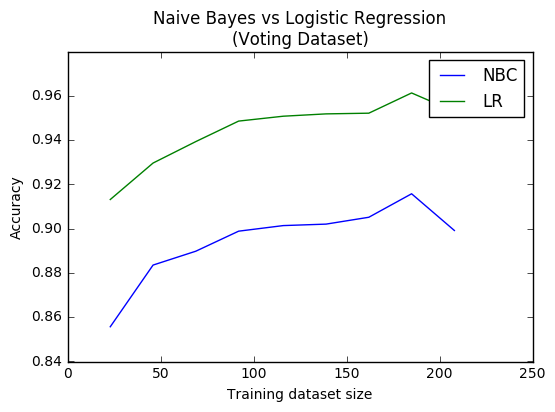

In [6]:
plt.plot(xDataNBC, yDataNBC, 'b-', label='NBC')
plt.plot(xDataLR, yDataLR, 'g-', label='LR')
plt.xlabel('Training dataset size')
plt.ylabel('Accuracy')
plt.title('Naive Bayes vs Logistic Regression\n(Voting Dataset)')
plt.legend()
plt.show()

In [19]:
# Full Voting dataset
import scipy.stats
X, y = cp.load(open('voting-full.cPickle','rb'))
nbc = NBC(feature_types = ['b','b','b','b','b','b','b','b','b','b','b','b','b','b','b','b'], num_classes = 2)

NUM_PERMUTATIONS = 300

for i in range (0, X.shape[1]):
    a = X[:,i]
    a[a==2] = scipy.stats.mode(a)[0]
    X[:,i] = a # replace with mode


lr = LogisticRegression()

# Hand in 1
lr.fit(X=X, y=y) 
w = lr.coef_
C = (w[0].T).dot(w[0])
C *= 0.1
print "w =", w[0]
print "C =1 /", C


# values for plot
xDataNBC = []
yDataNBC = []
xDataLR = []
yDataLR = []

N, D = X.shape

print "Starting training with", NUM_PERMUTATIONS, "permutations"

# dont include 100%, otherwise we have nothing to test against.
for k in range(1, 10):
    accuracyNBC = 0
    accuracyLR = 0
    Ntrain = int((k/float(10)) * N)
    print "Training on", Ntrain, "values"

    for permutation in range(NUM_PERMUTATIONS):
        #print N
        #print Ntrain
        shuffler = np.random.permutation(N)
        Xtrain = X[shuffler[:Ntrain]]
        ytrain = y[shuffler[:Ntrain]]
        Xtest = X[shuffler[Ntrain:]]
        ytest = y[shuffler[Ntrain:]]

        # NBC
        nbc.fit(Xtrain,ytrain)
        predictedNBC = nbc.predict(Xtest)
        accuracyNBC += getAccuracy(actual=ytest, predicted=predictedNBC)


        # Logisitic Regression
        lr.fit(X=Xtrain, y=ytrain) 
        predictedLR = lr.predict(Xtest)
        accuracyLR += getAccuracy(actual=ytest, predicted=predictedLR)
   
    accuracyNBC /= NUM_PERMUTATIONS
    accuracyLR /= NUM_PERMUTATIONS

    
    xDataNBC.append(Ntrain)
    yDataNBC.append(accuracyNBC)
    xDataLR.append(Ntrain)
    yDataLR.append(accuracyLR)
    
print "Finished Training"

New NBC created ['b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b'] 2 {}
w = [ 0.36889581  0.37366086  1.70736808 -3.55532533 -0.70106687  0.4256941
 -0.3785337  -0.43131934  1.04467434 -0.92037742  2.05285924 -0.52220892
 -0.18615829 -0.44376723  1.0858772   0.05729999]
C =1 / 2.46725540552
Starting training with 300 permutations
Training on 43 values
Training on 87 values
Training on 130 values
Training on 174 values
Training on 217 values
Training on 261 values
Training on 304 values
Training on 348 values
Training on 391 values
Finished Training


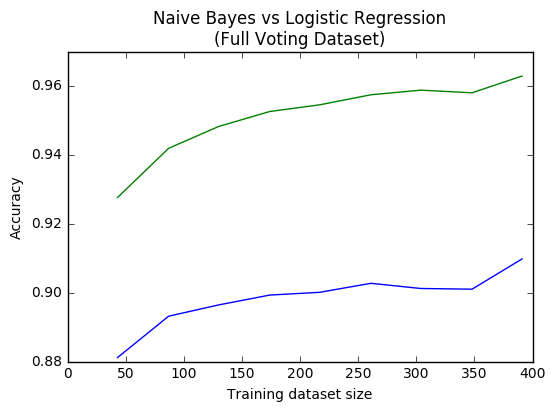

In [21]:
plt.plot(xDataNBC, yDataNBC, 'b-', label='NBC')
plt.plot(xDataLR, yDataLR, 'g-', label='LR')
plt.xlabel('Training dataset size')
plt.ylabel('Accuracy')
plt.title('Naive Bayes vs Logistic Regression\n(Full Voting Dataset)')
#plt.legend()
plt.show()